In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import multirecording_spikeanalysis_edit as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = timestamp_start + 10000
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [3]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [4]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data)

All set to analyze


In [5]:
spike_analysis.wilcox_baseline_v_event_collection('omission', 10, 10)

All differences are zero for unit 6.
All differences are zero for unit 60.
All differences are zero for unit 4.
All differences are zero for unit 59.
All differences are zero for unit 79.
All differences are zero for unit 39.
All differences are zero for unit 28.
All differences are zero for unit 29.
All differences are zero for unit 54.
All differences are zero for unit 52.
All differences are zero for unit 48.
All differences are zero for unit 74.
All differences are zero for unit 78.
All differences are zero for unit 5.
All differences are zero for unit 53.
All differences are zero for unit 17.
All differences are zero for unit 3.
All differences are zero for unit 80.
All differences are zero for unit 17.
All differences are zero for unit 43.
All differences are zero for unit 25.
All differences are zero for unit 35.
All differences are zero for unit 16.
All differences are zero for unit 34.
All differences are zero for unit 47.
All differences are zero for unit 20.
All differences 

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\Documents\GitHub\npc_playground\multirecording_spikeanalysis_edit.py:1012: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if th

All differences are zero for unit 252.
All differences are zero for unit 44.
All differences are zero for unit 263.
All differences are zero for unit 262.
All differences are zero for unit 282.
All differences are zero for unit 134.
All differences are zero for unit 274.
All differences are zero for unit 186.
All differences are zero for unit 227.
All differences are zero for unit 250.
All differences are zero for unit 11.
All differences are zero for unit 132.
All differences are zero for unit 268.
All differences are zero for unit 275.
All differences are zero for unit 187.
All differences are zero for unit 271.
All differences are zero for unit 255.
All differences are zero for unit 272.


C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


All differences are zero for unit 86.


C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,139,1.0,1.000000,not significant,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s omission vs 10s baseline
1,7,0.0,0.500000,not significant,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s omission vs 10s baseline
2,76,0.0,0.317311,not significant,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s omission vs 10s baseline
3,84,1.0,1.000000,not significant,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s omission vs 10s baseline
4,170,0.0,0.317311,not significant,20230618_100636_standard_comp_to_omission_D2_s...,1-1,10s omission vs 10s baseline
...,...,...,...,...,...,...,...
85,89,3.0,0.625000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s omission vs 10s baseline
86,15,0.0,0.108809,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s omission vs 10s baseline
87,74,1.0,0.250000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s omission vs 10s baseline
88,22,0.0,0.125000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s omission vs 10s baseline


C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\short\anaconda3\Lib\sit

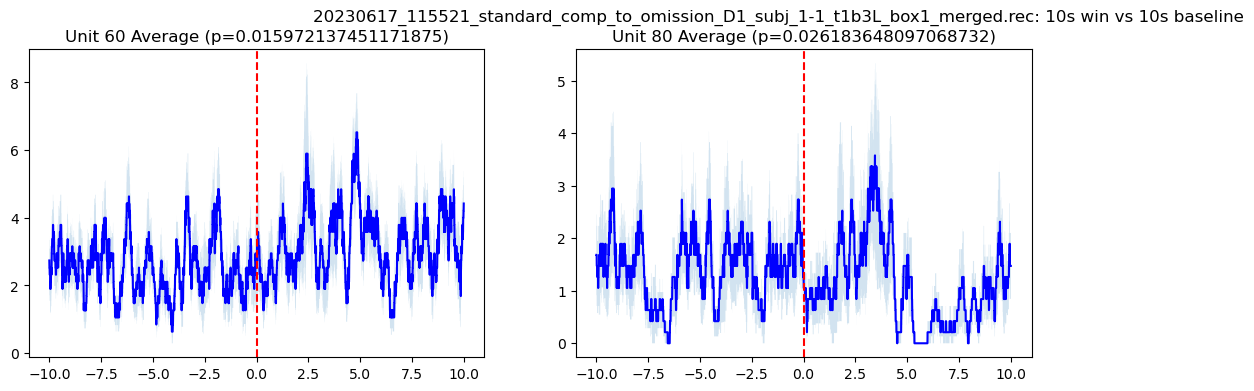

<Figure size 2000x0 with 0 Axes>

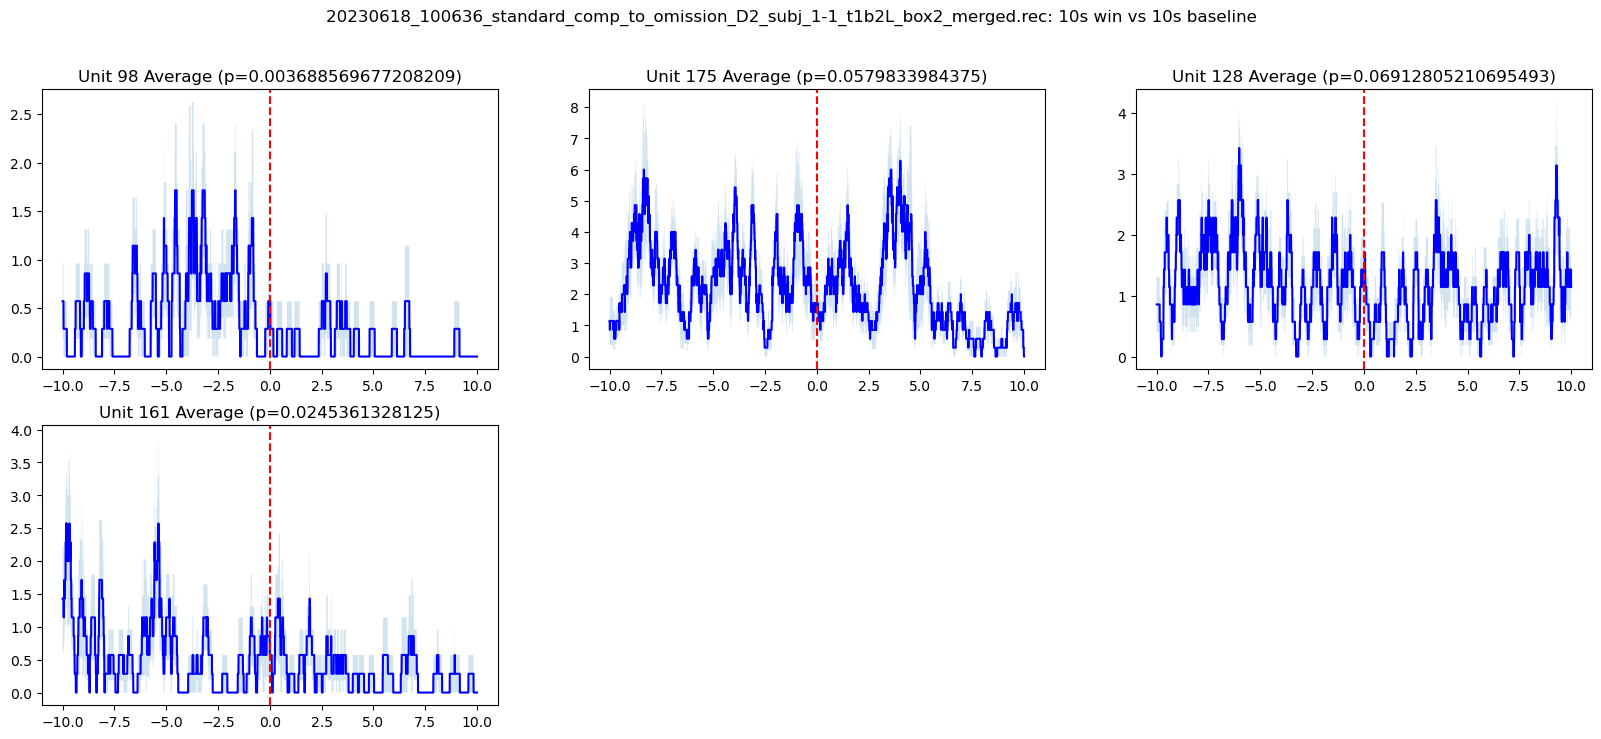

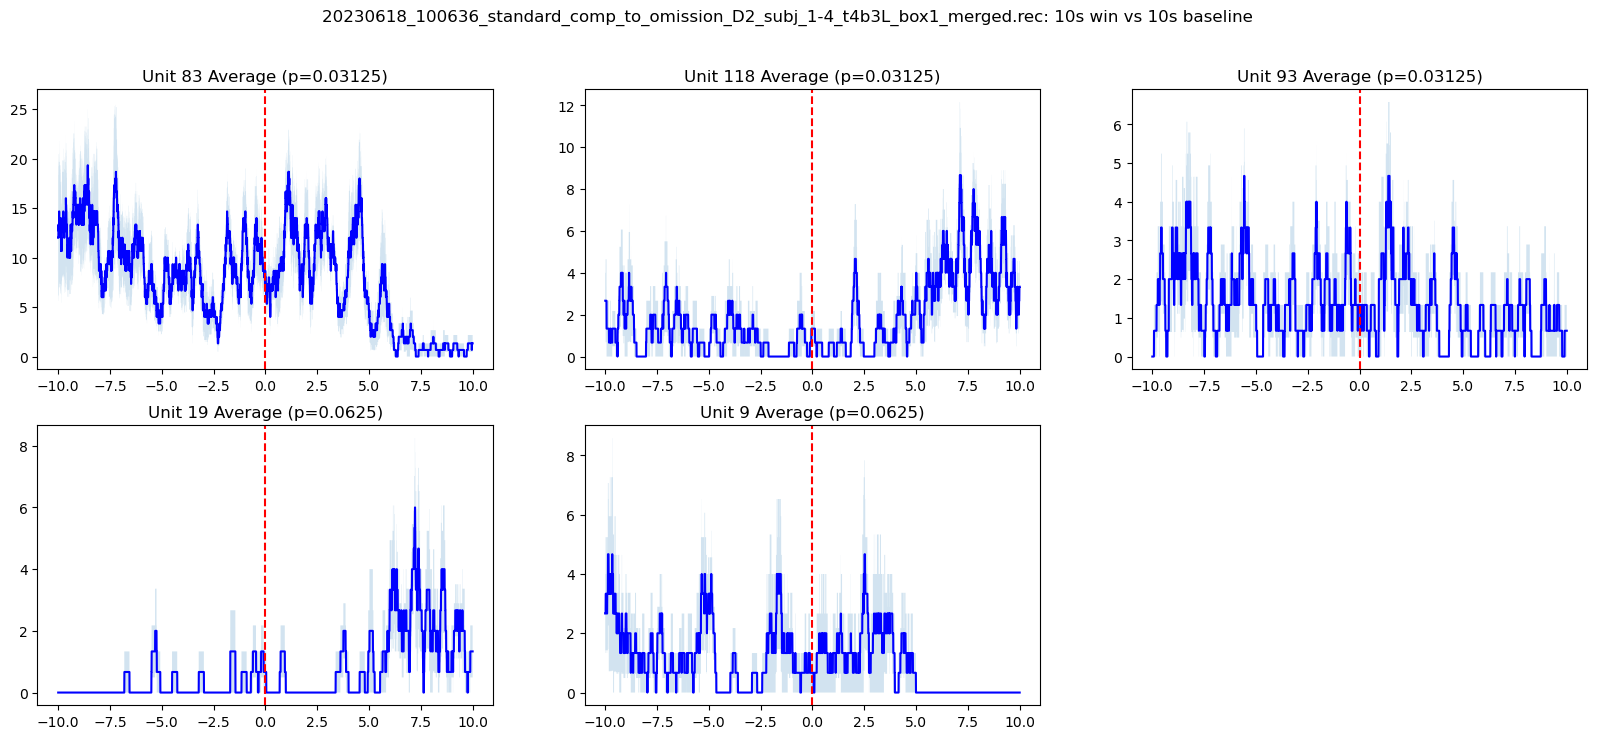

<Figure size 2000x0 with 0 Axes>

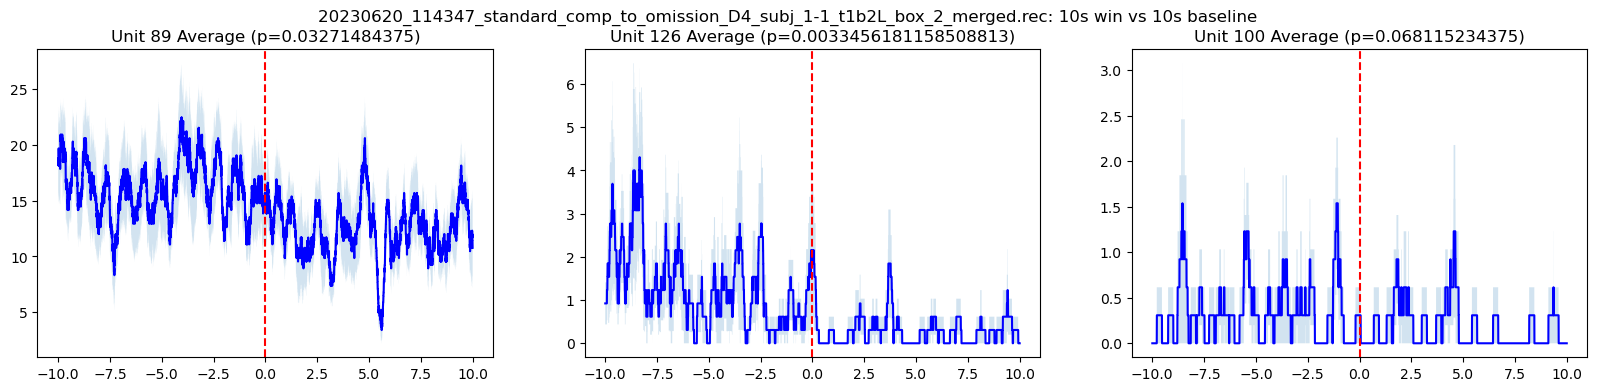

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,6,74.0,0.418041,not significant,20230617_115521_standard_comp_to_omission_D1_s...,1-1,10s win vs 10s baseline
1,60,36.0,0.015972,increases,20230617_115521_standard_comp_to_omission_D1_s...,1-1,10s win vs 10s baseline
2,4,78.0,0.515278,not significant,20230617_115521_standard_comp_to_omission_D1_s...,1-1,10s win vs 10s baseline
3,59,53.0,0.095512,not significant,20230617_115521_standard_comp_to_omission_D1_s...,1-1,10s win vs 10s baseline
4,79,40.0,0.083453,not significant,20230617_115521_standard_comp_to_omission_D1_s...,1-1,10s win vs 10s baseline
...,...,...,...,...,...,...,...
151,89,0.0,0.500000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s win vs 10s baseline
152,15,0.0,0.500000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s win vs 10s baseline
153,74,0.0,0.500000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s win vs 10s baseline
154,22,1.0,1.000000,not significant,20230621_111240_standard_comp_to_omission_D5_s...,1-4,10s win vs 10s baseline


In [6]:
spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10)